In [4]:
#load packages
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import soundfile as sf

In [5]:
#load the saved model 
json_file = open('GRU_56-60-5.json', 'r')
loaded_model_json = json_file.read()
loaded_model = keras.models.model_from_json(loaded_model_json)

#load weights
loaded_model.load_weights("GRU_56-60-5.h5")

In [6]:
#load test data
path = 'x:/Steering/Recordings/Processed/'
testX = np.load(path + 'TestX_GRU_56-60-5.npy')
testY = np.load(path + 'TestY_GRU_56-60-5.npy')
one_hot_test = np.load(path + 'OneHot_GRU_56-60-5.npy')

In [7]:
one_hot_test


array([[[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]],

       ...,

       [[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]],

       [[0.,

In [8]:
loaded_model.compile(loss='mean_squared_error',
    optimizer='Adam',
           metrics=['categorical_accuracy'])

In [9]:
loaded_model.evaluate(testX,one_hot_test,verbose=1)

3534/3534 [==============================] - 1s 415us/step


[0.0556800492786727, 0.821354462591753]

In [10]:
#process weights
weights_first_layer = loaded_model.layers[0].get_weights()[0]
biases_first_layer = loaded_model.layers[0].get_weights()[1]

weights_second_layer = loaded_model.layers[1].get_weights()[0]
biases_second_layer = loaded_model.layers[1].get_weights()[1]


In [11]:
weights_first_layer = np.vstack([biases_first_layer, weights_first_layer])
weights_second_layer = np.vstack([biases_second_layer, weights_second_layer])


In [12]:
weights_first_layer_norm = weights_first_layer / abs(weights_first_layer).max()
#biases_first_layer_norm = biases_first_layer / abs(biases_first_layer).max()

weights_second_layer_norm = weights_second_layer / abs(weights_second_layer).max()
#biases_second_layer_norm = biases_second_layer / abs(biases_second_layer).max()


In [13]:
weights_first_layer_norm.shape, weights_second_layer_norm.shape

((164, 168), (57, 5))

In [14]:
abs(weights_first_layer).max(), abs(weights_second_layer).max()

(3.511628, 0.6504975)

In [15]:
testY_1 = testY.reshape(3534*60,1)

In [16]:
testX_1 = loaded_model.predict_classes(testX).reshape(3534*60)

In [17]:
testX_1

array([3, 1, 3, ..., 4, 4, 4], dtype=int64)

In [18]:
#plot confusion matrix 
#confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cfm = confusion_matrix(testY_1,testX_1)

In [19]:
cfm

array([[15227,  2019,     5,  2003,  1146],
       [  166, 69266,     5,  3317,    86],
       [    3,   729, 20293,   342,   893],
       [ 4478,  8196,    55, 39680,  5491],
       [  446,  2305,   428,  5767, 29694]], dtype=int64)

In [20]:
cfm_norm = np.zeros((5,5))#[[0 for x in range(5)] for y in range(5)]
for idx in range(5):
    cfm_norm[idx,:] = cfm[idx,:] / sum(cfm[idx,:]) #len(testY[testY == idx + 1])      
cfm_norm = np.around(cfm_norm,decimals=3)

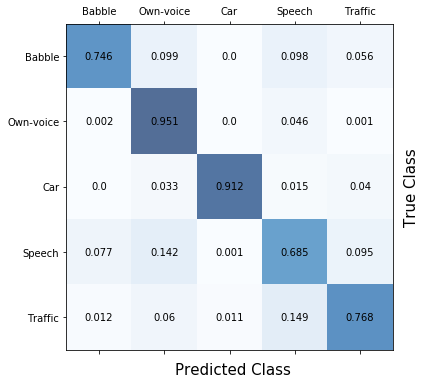

In [21]:
#nicer confusion matrix
fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cfm_norm,cmap=plt.cm.Blues,alpha=0.7)

for i in range(cfm_norm.shape[0]):
    for j in range(cfm_norm.shape[1]):
        ax.text(x=j,y=i, s=cfm_norm[i,j],va='center', ha= 'center')

ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])
ax.set_xticklabels(['Babble','Own-voice','Car','Speech','Traffic'])
ax.set_yticklabels(['Babble','Own-voice','Car','Speech','Traffic'])
ax.yaxis.set_label_coords(1.08,0.5)
ax.xaxis.set_label_coords(0.51,-0.04)
ax.set_xlabel('Predicted Class',fontsize=15)
ax.set_ylabel('True Class',fontsize=15)
plt.savefig('Conf_Mat_GRU',dpi=100)


In [22]:
FP = cfm_norm.sum(axis=0) - np.diag(cfm_norm)  
FN = cfm_norm.sum(axis=1) - np.diag(cfm_norm)
TP = np.diag(cfm_norm)
TN = cfm_norm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [25]:
ACC.mean(),TPR.mean(), FPR.mean()

(0.925025005001, 0.8125493493493494, 0.0468605776444111)